# Введение в искусственные нейронные сети
# Урок 6. Сегментация

## Практическое задание

<ol>
    <li>Попробуйте обучить нейронную сеть U-Net либо на другом датасете либо с другим бэкбоном (другой свёрточной частью). 
        Опишите в комментарии к уроку - какой результата вы добились от нейросети? Что помогло вам улучшить ее точность?
    </li>
    <li>*Попробуйте свои силы в задаче Carvana на Kaggle - https://www.kaggle.com/c/carvana-image-masking-challenge/overview</li>
    <li>*Сделайте свою реализацию U-Net на TensorFlow</li>
</ol>

In [ ]:
##### Copyright 2019 The TensorFlow Authors.

# Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [5]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-zp__u6y0
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-zp__u6y0
  Created wheel for tensorflow-examples: filename=tensorflow_examples-bcff8b9d1d6672b448a78e7dacb5ef54dce2c890_-cp36-none-any.whl size=136996 sha256=c4e25ef5dc40dc4daa71573f25bc1fe349e9352125ac233481f8b1a3dcccef2a
  Stored in directory: /tmp/pip-ephem-wheel-cache-g9w_3vpc/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

In [6]:
from __future__ import absolute_import, division, print_function, unicode_literals

from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt


import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')

In [ ]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [8]:
builder = tfds.builder('oxford_iiit_pet:3.1.0')

info = builder.info

print(info)

config = tfds.download.DownloadConfig(register_checksums = True)

builder.download_and_prepare(download_config=config)

dataset = builder.as_dataset()

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.1.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.
',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and J

In [9]:
dataset, info = tfds.load('oxford_iiit_pet', with_info=True, download=False)

In [10]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [11]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [12]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [13]:
TRAIN_LENGTH = info.splits['train'].num_examples

In [14]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [15]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [16]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [17]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

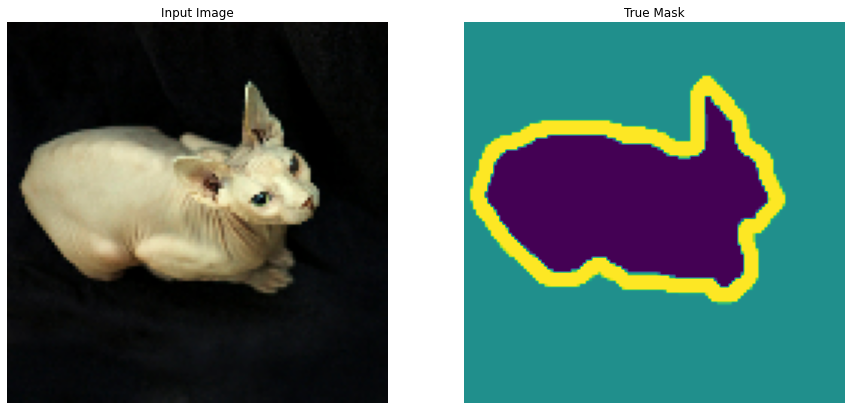

In [18]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [19]:
OUTPUT_CHANNELS = 3

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64x96
    'block_3_expand_relu',   # 32x32x144
    'block_6_expand_relu',   # 16x16x192
    'block_13_expand_relu',  # 8x8x576
    'block_16_project',      # 4x4x (block_16_project/Conv2D:0' shape=(None, 4, 4, 320))
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [ ]:
[layer.output for layer in base_model.layers]

[<tf.Tensor 'input_1:0' shape=(None, 128, 128, 3) dtype=float32>,
 <tf.Tensor 'Conv1_pad/Pad:0' shape=(None, 129, 129, 3) dtype=float32>,
 <tf.Tensor 'Conv1/Conv2D:0' shape=(None, 64, 64, 32) dtype=float32>,
 <tf.Tensor 'bn_Conv1/cond/Identity:0' shape=(None, 64, 64, 32) dtype=float32>,
 <tf.Tensor 'Conv1_relu/Relu6:0' shape=(None, 64, 64, 32) dtype=float32>,
 <tf.Tensor 'expanded_conv_depthwise/depthwise:0' shape=(None, 64, 64, 32) dtype=float32>,
 <tf.Tensor 'expanded_conv_depthwise_BN/cond/Identity:0' shape=(None, 64, 64, 32) dtype=float32>,
 <tf.Tensor 'expanded_conv_depthwise_relu/Relu6:0' shape=(None, 64, 64, 32) dtype=float32>,
 <tf.Tensor 'expanded_conv_project/Conv2D:0' shape=(None, 64, 64, 16) dtype=float32>,
 <tf.Tensor 'expanded_conv_project_BN/cond/Identity:0' shape=(None, 64, 64, 16) dtype=float32>,
 <tf.Tensor 'block_1_expand/Conv2D:0' shape=(None, 64, 64, 96) dtype=float32>,
 <tf.Tensor 'block_1_expand_BN/cond/Identity:0' shape=(None, 64, 64, 96) dtype=float32>,
 <tf.Te

In [22]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [23]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [24]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [26]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [27]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

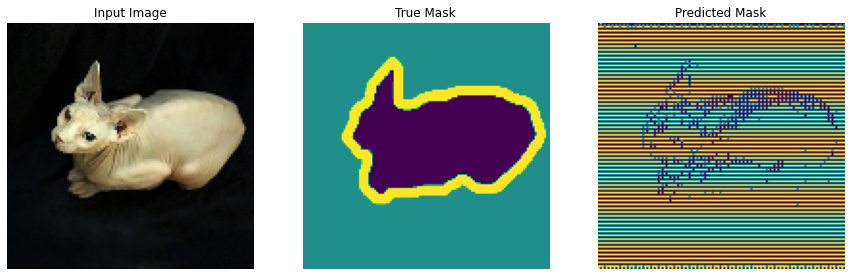

In [ ]:
show_predictions()

Сначала обучим исходную модель MobileNetV2 на 10 эпохах

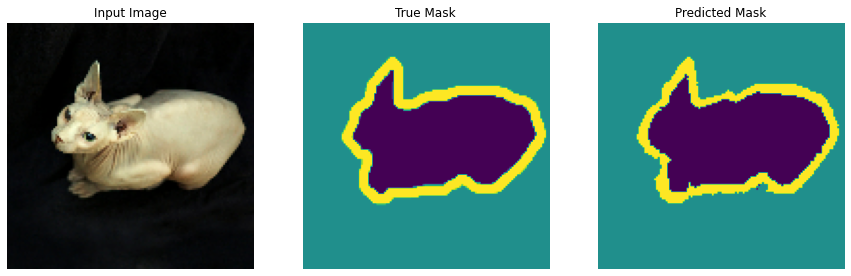


Sample Prediction after epoch 10

57/57 [==============================] - 191s 3s/step - loss: 0.2138 - accuracy: 0.9075 - val_loss: 0.2707 - val_accuracy: 0.8927
Wall time: 32min 32s


In [ ]:
%%time
tf.random.set_seed(48)
EPOCHS = 10 # увеличьте при необходимости
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

Теперь рассмотрим предыдущую модификацию MobileNet. Сначала определим слои которые нам нужны

In [20]:
base_model = tf.keras.applications.MobileNet(input_shape=[128, 128, 3], include_top=False)

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
[layer.output for layer in base_model.layers]

[<tf.Tensor 'input_2:0' shape=(None, 128, 128, 3) dtype=float32>,
 <tf.Tensor 'conv1_pad/Pad_1:0' shape=(None, 129, 129, 3) dtype=float32>,
 <tf.Tensor 'conv1/Conv2D_1:0' shape=(None, 64, 64, 32) dtype=float32>,
 <tf.Tensor 'conv1_bn/cond_1/Identity:0' shape=(None, 64, 64, 32) dtype=float32>,
 <tf.Tensor 'conv1_relu/Relu6_1:0' shape=(None, 64, 64, 32) dtype=float32>,
 <tf.Tensor 'conv_dw_1/depthwise_1:0' shape=(None, 64, 64, 32) dtype=float32>,
 <tf.Tensor 'conv_dw_1_bn/cond_1/Identity:0' shape=(None, 64, 64, 32) dtype=float32>,
 <tf.Tensor 'conv_dw_1_relu/Relu6_1:0' shape=(None, 64, 64, 32) dtype=float32>,
 <tf.Tensor 'conv_pw_1/Conv2D_1:0' shape=(None, 64, 64, 64) dtype=float32>,
 <tf.Tensor 'conv_pw_1_bn/cond_1/Identity:0' shape=(None, 64, 64, 64) dtype=float32>,
 <tf.Tensor 'conv_pw_1_relu/Relu6_1:0' shape=(None, 64, 64, 64) dtype=float32>,
 <tf.Tensor 'conv_pad_2/Pad_1:0' shape=(None, 65, 65, 64) dtype=float32>,
 <tf.Tensor 'conv_dw_2/depthwise_1:0' shape=(None, 32, 32, 64) dtype=

In [21]:
base_model = tf.keras.applications.MobileNet(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'conv_pw_1_relu',   # 64x64 (conv_pw_1_relu/Relu6:0' shape=(None, 64, 64, 64))
    'conv_pw_2_relu',   # 32x32 (conv_pw_2_relu/Relu6:0' shape=(None, 32, 32, 128))
    'conv_pw_4_relu',   # 16x16 (conv_pw_4_relu/Relu6:0' shape=(None, 16, 16, 256))
    'conv_pw_6_relu',   # 8x8 (conv_pw_6_relu/Relu6:0' shape=(None, 8, 8, 512))
    'conv_pw_13',       # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

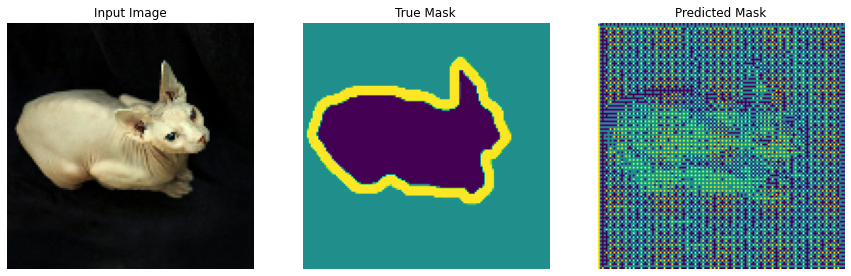

In [28]:
show_predictions()

И точно так же обучим на 10 эпохах

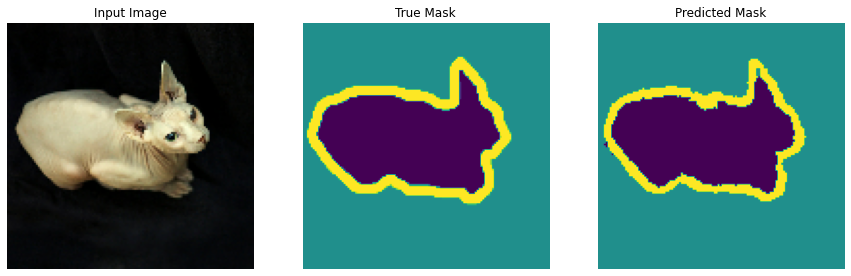


Sample Prediction after epoch 10

115/115 [==============================] - 397s 3s/step - loss: 0.2196 - accuracy: 0.9043 - val_loss: 0.2784 - val_accuracy: 0.8876
CPU times: user 2h 6min 28s, sys: 1min 49s, total: 2h 8min 18s
Wall time: 1h 7min 21s


In [29]:
%%time
tf.random.set_seed(48)
EPOCHS = 10 # увеличьте при необходимости
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

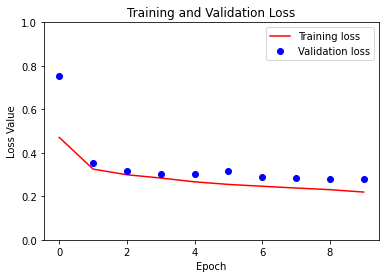

In [30]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

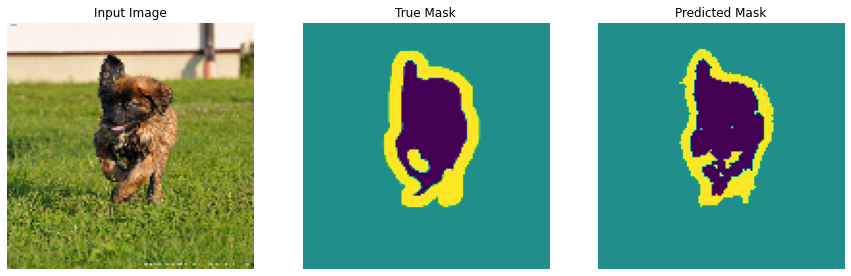

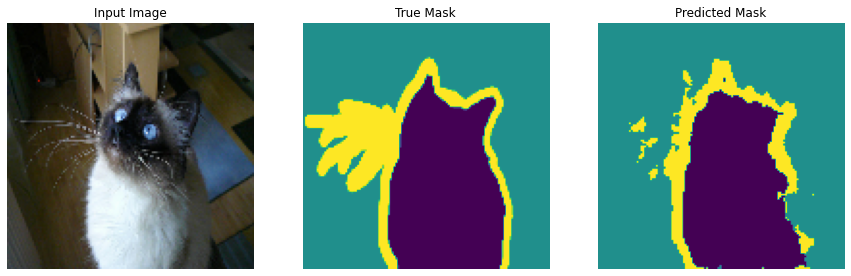

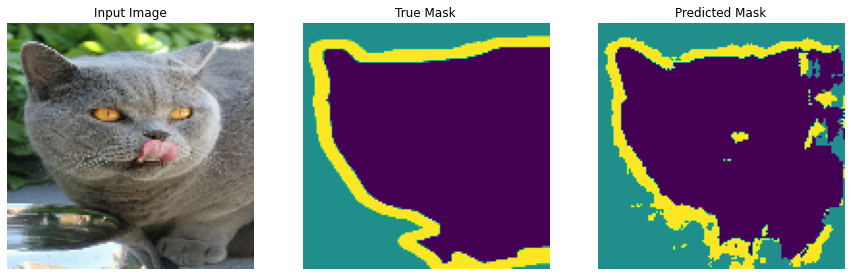

In [31]:
show_predictions(test_dataset, 3)

### Выводы:
В результате сравнения версий MobileNetV2 и MobileNet, выяснилось, что первая версия MobileNet оказалась чуть менее точная чем версия 2. Что вполне ожидаемо. У версии V2 точность но отложенной выборке 0.8927, а у V1 0.8876.